# Week 6, Lab \#5

*February 21, 2024*

**Check that you have all the necessary Python packages installed:**

```sh
pip install gdal rasterio affine matplotlib pyproj
```

## Introduction: Projections in Python

We've seen in class that spatial projections, or spatial reference systems (SRS), are often referred to by European Petroleum Survey Group (EPSG) codes. EPSG codes can be hard to remember, but there are two helpful resources:

- The `pyproj` library (see below)
- The [epsg.io](https://epsg.io) website

Our projections in Python are often represented using Well-Known Text (WKT), which includes a bunch of EPSG codes. Only one of those codes represents the SRS. WKT strings are how we store and represent a spatial projection in Python.

**If we need to look up the WKT for a given SRS (also known as a coordinate reference system or CRS), [we can use the `pyproj` library.](https://pyproj4.github.io/pyproj/stable/api/crs/crs.html)**

In [1]:
from osgeo import gdal
import rasterio as rio
from affine import Affine

In [3]:
# CRS (Coordinate Reference System), SRS, and "projection" all refer to the same thing
from pyproj import CRS

srs = CRS.from_user_input(4326)
srs.to_wkt()

'GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]'

## Lab 5, Part 1: NOAA Temperature Data

For the first part of this lab, we'll be working with [the gridded NOAA temperature data from before](http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/index.html). I've modified these data so they can be read as an array.

In [4]:
ds = gdal.Open('/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/NOAA_NCEP_CPC_gridded_deg0p5_Oct2021_to_Sep2022.tiff')
ds

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001CBB2927C90> >

If your version of `gdal` has an issue reading datasets over the web, you can instead download the data from the link below and save it to your hard drive:

[http://files.ntsg.umt.edu/data/GIS_Programming/data/NOAA_NCEP_CPC_gridded_deg0p5_Oct2021_to_Sep2022.tiff](http://files.ntsg.umt.edu/data/GIS_Programming/data/NOAA_NCEP_CPC_gridded_deg0p5_Oct2021_to_Sep2022.tiff)

The monthly temperature data range from October 2021 through September 2022. The array is 3-dimensional, where the first axis is the month and the last two axes are latitude and longitude (rows and columns).

In [5]:
data = ds.ReadAsArray()

data.shape

(12, 360, 720)

Hence, the first month of the year could be displayed like:

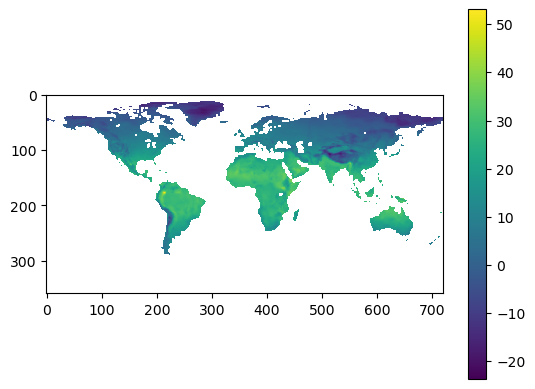

In [6]:
import matplotlib.pyplot as plt

plt.imshow(data[0])
plt.colorbar()
plt.show()

---

## Problem 5.1

**What's the maximum surface temperature over the past year?** Calculate and plot a map of the maximum surface temperature.

C:\Users\by197116\AppData\Local\Temp\ipykernel_11700\3578741766.py:3: RuntimeWarning: All-NaN slice encountered
  maxtemp = np.nanmax(data, axis = 0)


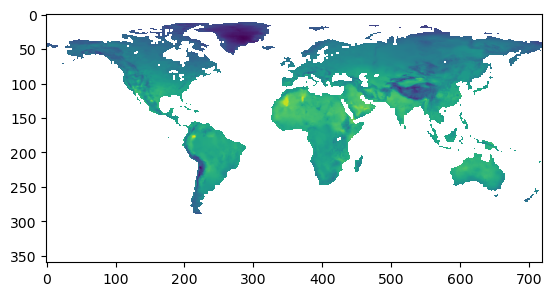

In [7]:
import numpy as np

maxtemp = np.nanmax(data, axis = 0)

plt.imshow(maxtemp)

---

## Problem 5.2

The NOAA dataset we downloaded looks like a proper GeoTIFF but it doesn't have the right spatial information.

In [8]:
ds.GetGeoTransform()

(0.0, 1.0, 0.0, 0.0, 0.0, -1.0)

If we wanted to write it to a file, we'd need to define both the projection and the affine transformation ("GeoTransform").

**Write the GeoTransform for this dataset as a Python `tuple`.** Recall that the GDAL "GeoTransform" is a sequence of 6 numbers that describe how this array of data should be oriented on the Earth's surface:

```py
(x_min, pixel_width, row_rotation, y_max, col_rotation, -pixel_height)
```

1. `x_min` is the minimum X coordinate, for example, the minimum or west-most Longitude.
2. `pixel_width` is the width of a raster pixel in the units used by the SRS, usually meters or degrees.
3. `row_rotation` describes how rows are oriented on the map; for North-up maps this is always zero.
4. `y_max` is the maximum Y coordinate, for example, the maximum or north-most Latitude.
5. `col_rotation` is similar to `row_rotation` and is always zero for North-up maps.
6. `-pixel_height` is the *negative* height of a raster pixel, in the units used by the SRS.

[You can read more about the GeoTransform here.](https://gdal.org/tutorials/geotransforms_tut.html)

The NOAA data are on a 0.5-degree by 0.5-degree image. [The NOAA NCEP website](http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/index.html) describes the axes of the gridded data as:

```
Time (time)	grid: /T (months since 1960-01-01) ordered (Jan 1948) to (Sep 2022) by 1.0 N= 897 pts :grid
Longitude (longitude)	grid: /X (degree_east) periodic (0.25E) to (0.25W) by 0.5 N= 720 pts :grid
Latitude (latitude)	grid: /Y (degree_north) ordered (89.75S) to (89.75N) by 0.5 N= 360 pts :grid
```

**Assume the west-most longitude of this grid is -179.75 W.**

You'll need to consider both the resolution of the raster *and* the geographic extent when writing the GeoTransform. 

In [9]:
# Write GeoTransform for 'ds' as a tuple

gt = (-179.75, 0.5, 0, 89.75, 0, -0.5)

---

## A Useful Function

Here is a function that will export a single-band raster dataset (NumPy array) to a GeoTIFF file.

In [10]:
from affine import Affine
import rasterio as rio

def raster_to_geotiff(filename, array, gt, wkt):
    '''
    Parameters
    ----------
    filename : str
        File path for the output GeoTIFF file
    array : numpy.ndarray
        A NumPy array
    gt : tuple or list
        A GeoTransform tuple
    wkt : str
        The WKT projection string
    '''
    ds = rio.open(
        filename, 'w', driver = 'GTiff', height = array.shape[0], width = array.shape[1], 
        count = 1, dtype = array.dtype, crs = wkt, transform = Affine.from_gdal(*gt))
    ds.write(array, 1)
    ds.close()

Using the GeoTransform from Problem 5.2 in combination with a WKT projection string, you can now export your data to a GeoTIFF file! The WKT projection string can be obtained:

In [11]:
wkt = ds.GetProjection()
wkt

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

---

## Problem 5.3

Using the `raster_to_geotiff()` function above, **export a GeoTIFF that shows the maximum surface temperature (from Problem 5.1) for only the Western Hemisphere (longitudes between -180 and 0).** How should you change the GeoTransform tuple (if at all)? Show all the code involved.

- **Plot the raster array here using `pyplot.imshow()`**
- **Don't submit a GeoTIFF! Just show all the steps involved as Python code.**

**Hint:** Check the shape of your data array. How many longitude columns do you have? How many *should* you have in the correct output?

---

In [12]:
np.shape(maxtemp)

(360, 720)

In [13]:
maxtemp_w = maxtemp[:, :360]

In [14]:
np.shape(maxtemp_w)

(360, 360)

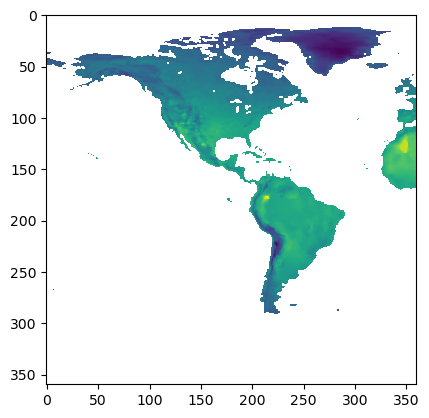

In [15]:
plt.imshow(maxtemp_w)

In [16]:
raster_to_geotiff(filename = "T:/GPHY_489/Students/by197116/maxtemp_w.tiff",
                  array = maxtemp_w,
                  gt = gt,
                  wkt = wkt
                 )

## Problem 5.4

Using the `raster_to_geotiff()` function above, **export a GeoTIFF that shows only the continent of Africa** (exact latitude/longitude bounding box doesn't matter). How should you change the GeoTransform tuple (if at all)? Show all the code involved. You will want to check your results in a Desktop GIS program to make sure that the image is correctly registered.

- **Plot the raster array here using `pyplot.imshow()`**
- **Don't submit a GeoTIFF! Just show all the steps involved as Python code.**


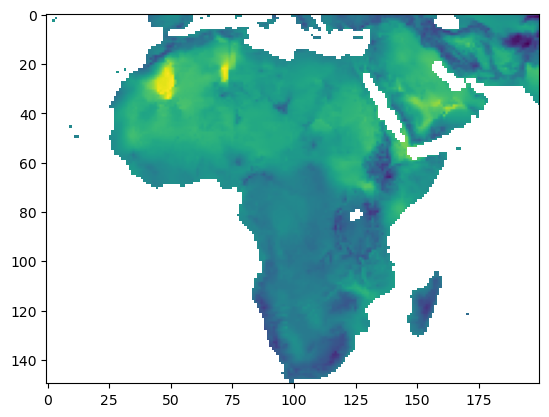

In [27]:
# Bounding box for Africa (pixel coordinates in image)
# x_min = 300
# x_max = 500
# y_min = 250
# y_max = 100
arr_africa = maxtemp[100:250, 300:500]

# Reminder of original geotransform: 
gt = (-179.75, 0.5, 0, 89.75, 0, -0.5)

# Convert pixel values of bounding box to latlong coordinates
x_min = gt[0] + 300 * gt[1]
y_max = gt[3] + 100 * gt[5]

# The x_min and y_max values of the geotransform tuple should be changed according to the bounding box
gt_africa = (x_min, 0.5, 0, y_max, 0, -0.5)

# Save as geotiff
raster_to_geotiff(filename = "T:/GPHY_489/Students/by197116/africa.tiff",
                  array = arr_africa,
                  gt = gt_africa,
                  wkt = wkt
                 )

# Plot
plt.imshow(arr_africa)

---

## Lab 5, Part 2: Alaska Burned-Area Orthoimage

For this part of the lab, we'll be using the burned-area orthoimage from our last class session.

In [22]:
from osgeo import gdal

ds = gdal.Open('/vsicurl/http://files.ntsg.umt.edu/data/GIS_Programming/data/NEON_ortho.tif')

Recall that this is a multi-band raster image with Red, Green, and Blue (RGB) channels.

In [23]:
rgb = ds.ReadAsArray()
rgb.shape

(3, 1000, 1000)

For example, the Red channel could be plotted like this:

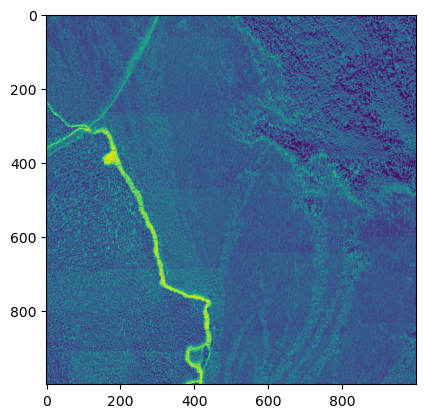

In [25]:
plt.imshow(rgb[0])

In [28]:
rgb[0].dtype

dtype('uint8')

---

## Problem 5.5

**Generate a binary mask (array with values that are only 0 or 1) that covers the burned area (and only the burned area) in the Alaska orthoimage.** This mask should be based on the Normalized Difference Greenness Index (NDGI) image we generated in class.

- **Plot the NDGI image.**
- **Plot the binary mask showing burned area only.** There is no one right answer here: the exact appearance will depend on the threshold value you chose.

**Hints:**

Recall that the NDGI is calculated this way:

$$
\text{NDGI} = \frac{G - R}{G + R}
$$

Where $G$ and $R$ refer to the Green and Red bands, respectively.

Recall that low NDGI values correspond to low vegetation greenness; in this case, likely burned area. In order to identify NDGI values that correspond to burned area, you may need to:

1. Plot the NDGI image, noting the row and column axes.
2. Subset the NDGI image using row and column indices to slice out a small, representative burned area.
3. Compute summary statistics (e.g., `np.mean()`) on the sliced-out image. This should give you an idea of a range of NDGI values that generally represent burned area.
4. Using that range of burned-area NDGI values, create a boolean array (or binary mask) that corresponds to just burned-area pixels.

You can use slice notation to "zoom in" on specific parts of the image, as in this example, where we zoom in on a segment of the road in the Red band image.

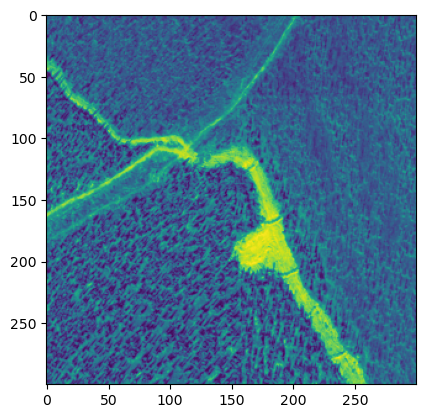

In [26]:
red = rgb[0]
plt.imshow(red[200:500,0:300])

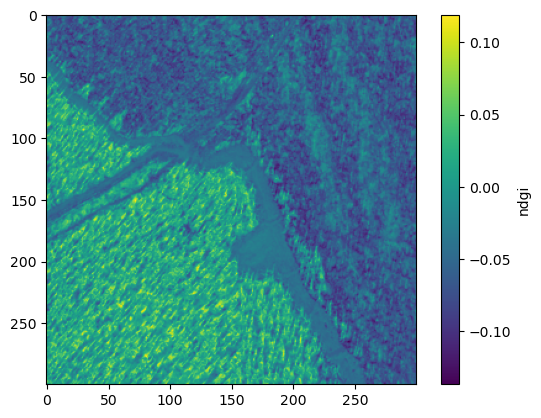

In [34]:
red = rgb[0].astype(np.float32)
green = rgb[1].astype(np.float32)
ndgi = (green - red)/(green + red)

plt.imshow(ndgi[200:500,0:300])
plt.colorbar(label = 'ndgi')

In [46]:
burned_slice = ndgi[50:100, 250:300]
print(f'Mean: {np.mean(burned_slice):.2f}', 
      f'\nMin: {np.min(burned_slice):.2f}',
      f'\nMax: {np.max(burned_slice):.2f}',
      f'\nRange: {np.max(burned_slice) - np.min(burned_slice):.2f}')

Mean: -0.06 
Min: -0.11 
Max: 0.03 
Range: 0.14


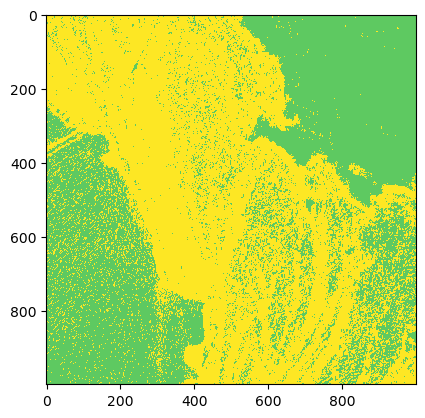

In [54]:
# Create mask for burned range based on above block
burned = ndgi < -0.01
burned = burned.astype(np.uint8)

# Create boolean array
burned_pixels = ndgi[burned]

# Plot
plt.imshow(burned, interpolation = 'nearest', vmin = np.min(burned_slice), vmax = np.max(burned_slice)) 

**Or, you could pick a threshold value by looking at a map of the NDGI image.**

---

## Optional Challenge: Band Histograms

Using the binary mask from Problem 5.5, extract Red, Green, and Blue pixel values from the original orthoimage. Show a series of three (3) histograms with these band values, one for each band, for both the burned *and* unburned area (i.e., invert the mask). Recall that histograms can be created with `matplotlib`:

```py
from matplotlib import pyplot

pyplot.hist(...)
```

Compare the histograms from burned and unburned areas. Do you see any patterns that may help you develop an automatic classifier that distinguishes between burned and unburned areas?